1803
1757
1766
1775
1782
1789
1795
1800
805
809
813
817
820
823
826
829
831
833
835
837
839
840
842
843
844
846
847
848
849
850


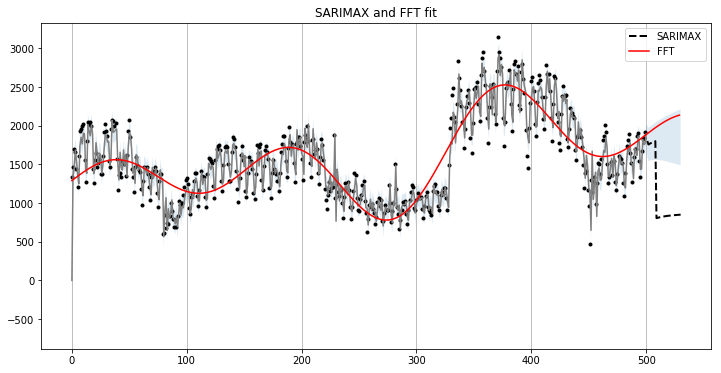

In [61]:
# Time Series: Predict the Web Traffic
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from numpy import fft
%matplotlib inline 

def readTrainData():
    inputfile = open("Data/input01.txt", "r")
    num_tests  = int(inputfile.readline())
    x = []
    y = []
    for i in range(num_tests):
        x.append(i)
        y.append(int(inputfile.readline())) 
    return num_tests, x, y

def readTestData():
    num_tests  = int(input())
    x = []
    y = []
    for i in range(num_tests):
        x.append(i)
        y.append(int(input()))                 
    return num_tests, x, y

def fourierExtrapolation(x, n_predict):
    n = len(x)
    n_harm = 3                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

nforecast = 30
num_tests, x, y = readTrainData()
#num_tests, x, y = readTestData()

# SARIMAX fit
model = sm.tsa.statespace.SARIMAX(y, trend='c', order=(1,1,4))
res = model.fit(disp=False, maxiter=200)
#print(res.summary())
predict = res.get_prediction(end=model.nobs + nforecast)
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

# FFT fit
extrapolation = fourierExtrapolation(y, nforecast)

# Graph
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(y, 'k.')

#if num_tests == 500:
#    for i in range(9,31):
#        predict.predicted_mean[model.nobs+i] = predict.predicted_mean[model.nobs+i] - 1000

# Plot SARIMAX
ax.plot(idx[:-nforecast], predict.predicted_mean[:-nforecast], 'gray')
ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2, label = 'SARIMAX')
ax.fill_between(idx, predict_ci[:, 0], predict_ci[:, 1], alpha=0.15)
# Plot FFT
ax.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'FFT')

ax.set(title='SARIMAX and FFT fit');
ax.legend()

print(*list(map(int, predict.predicted_mean[-nforecast:])), sep = "\n")